Many astronomers, particularly in imaging-focused research areas like my own, have used image alignment code written by others without struggling through writing their own. 

Sometimes, you really should just use the library code so you can publish in a timely fashion. Really, though, you should understand exactly what's going on. Otherwise, you may find yourself with pointed questions from your coauthors (or your referees) that you're unable to answer!

Fast image interpolation is a cornerstone of computer graphics. We take this for granted today, but being able to zoom, scale, translate, and rotate images requires doing operations on thousands of pixels at sixty frames-per-second for applications like image editors or animation tools.

Since it is so fundamental, this topic has already been explained many ways by many people. Now I'm adding my own version to the mix.

## The preliminaries

First, we need the usual Python tools for numerical computing and plotting:

In [1]:
%config InlineBackend.figure_formats = ['retina']
%config InlineBackend.print_figure_kwargs = {'facecolor': (1.0, 1.0, 1.0, 0.0)}
import numpy as np
import matplotlib.pyplot as plt

Make the plots a little more science-y:

In [2]:

plt.rc('image', 
    # (0, 0) is in lower-left as conventional in science,
    # not upper-left as in computer graphics
    origin='lower',
    # we don't need matplotlib to make smooth images; we'll do that ourselves
    interpolation='nearest',
    cmap='Blues'
)
plt.rc('figure', figsize=(5, 3))



The first order of business is to get an image to interpolate:

In [3]:
def f_test(npix):
    '''Create a square npix x npix array of zeros and draw a capital F
    that is upright and facing right when plotted with (0,0) at lower left
    as regions of ones'''
    f_test = np.zeros((npix, npix))
    mid = npix // 2
    stem = (slice(mid//8, npix - mid//8), slice((mid - mid // 4) - mid//8, (mid - mid//4) + mid // 8))
    f_test[stem] = 1
    bottom = (slice(mid - mid//8, mid + mid//8), slice((mid - mid // 4) - mid//8, (mid - mid//4) + 2*mid//3))
    f_test[bottom] = 1
    top = (slice(npix - mid//8 - mid // 4, npix - mid//8), slice((mid - mid // 4) - mid//8, (mid - mid//4) + mid))
    f_test[top] = 1
    return f_test

That makes an image like this.

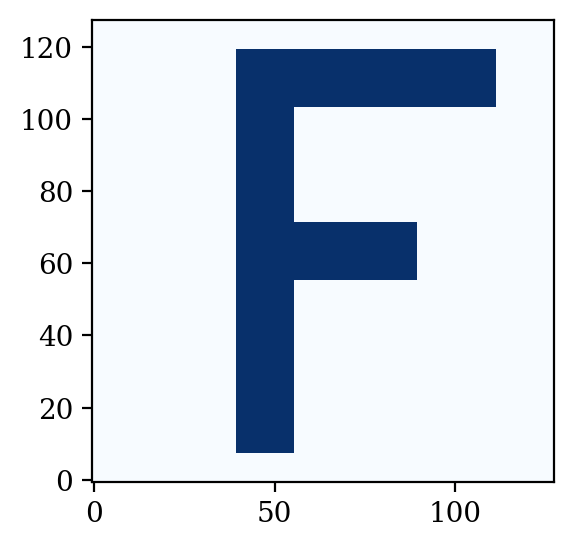

In [4]:
n_pix = 128
src = f_test(n_pix)
plt.imshow(src)

The "F" shape will make it clear when we flip the parity of the image, as well as showing which direction we're rotating when we rotate.

## The simplest transformation

The simplest transformation is a full-pixel (integer) translation. Let's make an empty image...

In [5]:
dest = np.zeros((n_pix, n_pix))

...and fill it with the above pattern, shifted ten pixels to the right.

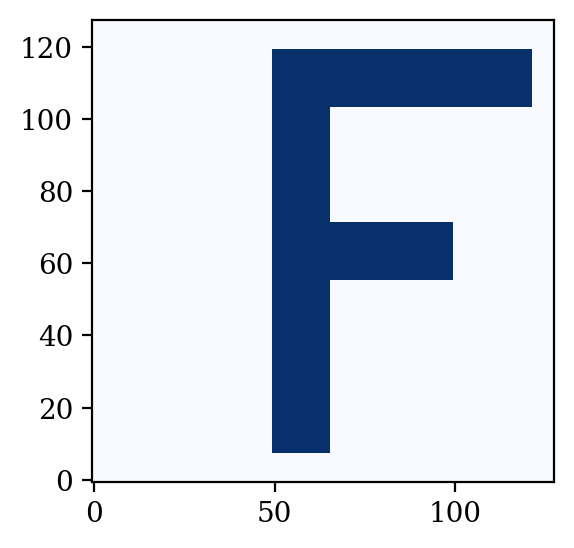

In [6]:
dx = 10
for dest_y in range(dest.shape[0]):
    for dest_x in range(dest.shape[1]):
        src_y, src_x = dest_y, dest_x - dx
        dest[dest_y, dest_x] = src[src_y, src_x]
plt.imshow(dest)

(We're cheating a little and just using NumPy indexing behavior to handle out-of-bounds coordinates—i.e. a negative `src_x`. Moving ten pixels left wouldn't work.)

There are a few things that should stand out to you about the above code. 

### Thing 1: loops

The first is that we have loops: in fact, a nested loop, which implies $O(n^2)$ scaling in the dimension of the image. There's no way around this; we have to visit every pixel to set its value. However, Python users know loops are slow-ish.

Let's compare a simple nested loop that sums all the pixels in the `src` image. First, the Python implementation:

In [7]:
%%timeit
accum = 0
for j in range(n_pix):
    for i in range(n_pix):
        accum += src[j, i]

1.51 ms ± 18.2 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


Not **so** bad, unless you do it a few thousand times. But it could be much faster:

In [8]:
%timeit np.sum(src)

4.74 μs ± 42.9 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


NumPy is still looping over all the elements of the array, but it does so in optimized C code instead of Python. That's enough to get a *three orders of magnitude* speedup.

So, be warned: the interpolation code developed in this post is optimized for clarity, not speed. (Maybe in another blog post!)

### Thing 2: loop over `dest`, not `src`

It was unintuitive (at least, to me) that the interpolation function to transform _from_ some image `src` _to_ some image `dest` involves looping over the pixels in `dest`. But, of course, the destination's pixel coordinates are fixed. We can't write a value into the 2.75'th pixel on an axis, just the 2nd or the 3rd pixel. So, we start with the destination pixel coordinates `dest_x` and `dest_y` and transform the coordinate to find the relevant part of the source image (that's the `src_y, src_x = dest_y, dest_x - dx` in the example above).

## Coordinate transformations

The typical representation of coordinate transformations for 2D graphics is as an affine transformation matrix. For the coordinates `dest_x, dest_y` we define a coordinate vector $\vec{v} = \begin{bmatrix}x \\ y \\ 1\end{bmatrix}$. The extra $1$ entry makes this an "augmented" vector, meaning the transform matrix becomes a $3 \times 3$ matrix instead of $2 \times 2$.

Without this extra entry, the transformation matrix could not represent a translation of the original coordinates. To get the 2D coordinates after transforming, simply drop the last entry of the vector.

As a quick refresher, here are the affine transformation matrices. (See [Wikipedia](https://en.wikipedia.org/wiki/Affine_transformation#Image_transformation) for more details, pictures, etc.)

### Translation

$$
\begin{bmatrix}x + \Delta x \\ y + \Delta y \\ 1\end{bmatrix} = 
\begin{bmatrix}
1 & 0 & \Delta x\\
0 & 1 & \Delta y \\
0 & 0 & 1
\end{bmatrix}

\begin{bmatrix}x \\ y \\ 1\end{bmatrix}
$$


### Scaling

$$
\begin{bmatrix}s_x x\\ s_y y\\ 1\end{bmatrix} = 
\begin{bmatrix}
s_x & 0 & 0\\
0 & s_y & 0\\
0 & 0 & 1
\end{bmatrix}

\begin{bmatrix}x \\ y \\ 1\end{bmatrix}
$$

Note that a parity flip (i.e. reversing the X or Y direction) is just a special case of scaling with a scale factor < 0.

### Rotation

$$
\begin{bmatrix}x'\\ y'\\ 1\end{bmatrix} = 
\begin{bmatrix}
\cos \theta & -\sin \theta & 0\\
\sin \theta & \cos \theta & 0\\
0 & 0 & 1
\end{bmatrix}
\begin{bmatrix}x \\ y \\ 1\end{bmatrix}
$$


### Shearing

$$
\begin{bmatrix}x'\\ y'\\ 1\end{bmatrix} = 
\begin{bmatrix}
1 & c_x & 0\\
c_y & 1 & 0\\
0 & 0 & 1
\end{bmatrix}
\begin{bmatrix}x \\ y \\ 1\end{bmatrix}
$$



### Who's getting transformed, anyway?

To find the relevant part of `src` given `dest_x, dest_y`, we transform from the destination image's pixel coordinates back to source image pixel coordinates. That means we have to think carefully about what's moving.

Suppose you have a feature at $(1, 1)$ in the source image and you want to place it at $(2, 3)$ in the destination image (i.e. a displacement of $+1$ in $x$ and $+2$ in $y$). That means when you transform $(2, 3)$ you should get $(1, 1)$, which means the $\Delta x$ and $\Delta y$ in the example above should be **negative**:

$$
\begin{bmatrix}
1 & 0 & -1\\
0 & 1 & -2\\
0 & 0 & 1
\end{bmatrix}

\begin{bmatrix}2 \\ 3 \\ 1\end{bmatrix}
=
\begin{bmatrix}2 - 1 \\ 3 - 2 \\ 1\end{bmatrix}
=\begin{bmatrix}1 \\1\\ 1\end{bmatrix}
$$

So, when constructing a transformation, you must always be clear about whether you're expressing the image's motion or the coordinate transformation "back" to the source image pixels.

## Nearest-neighbor interpolation

Technically, interpolation just means estimating values for new points at which we have no data. Using the nearest point where we *do* have data is not very accurate, but for images with large regions of uniform values it does okay. It is also very easy to implement.

Taking our image transformation loop from above, we change the way `src_x` and `src_y` are computed:

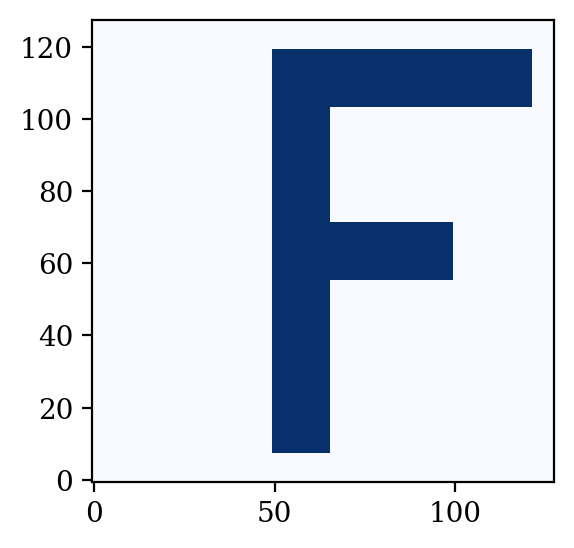

In [9]:
dx = 10
transform_mtx = np.array([
    # n.b. transforming the coordinate so x' = x - 10, moving image in +x by 10
    [1, 0, -dx],
    [0, 1, 0],
    [0, 0, 1]
])
for dest_y in range(dest.shape[0]):
    for dest_x in range(dest.shape[1]):
        src_x, src_y, _ = transform_mtx @ [dest_x, dest_y, 1]
        dest[dest_y, dest_x] = src[src_y, src_x]
plt.imshow(dest)

So far, so good. But we're moving by whole pixels still, which is easy mode. What if we wanted to rotate by $\pi / 6$?

In [10]:
theta = np.pi / 6
transform_mtx = np.array([
    [np.cos(theta), -np.sin(theta), 0],
    [np.sin(theta), np.cos(theta), 0],
    [0, 0, 1]
])
try:
    for dest_y in range(dest.shape[0]):
        for dest_x in range(dest.shape[1]):
            src_x, src_y, _ = transform_mtx @ [dest_x, dest_y, 1]
            dest[dest_y, dest_x] = src[src_y, src_x]
    plt.imshow(dest)
except Exception as e:
    print(type(e).__name__, e)

IndexError only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


That's because we're no longer using only whole integers, so this is where the rounding to nearest neighboring pixels comes in. Let's just `round()`.

In [11]:
theta = np.pi / 6
transform_mtx = np.array([
    [np.cos(theta), -np.sin(theta), 0],
    [np.sin(theta), np.cos(theta), 0],
    [0, 0, 1]
])
try:
    for dest_y in range(dest.shape[0]):
        for dest_x in range(dest.shape[1]):
            src_x, src_y, _ = transform_mtx @ [dest_x, dest_y, 1]
            src_x, src_y = round(src_x), round(src_y)
            dest[dest_y, dest_x] = src[src_y, src_x]
    plt.imshow(dest)
except Exception as e:
    print(type(e).__name__, e)

IndexError index 128 is out of bounds for axis 0 with size 128


Still not good enough. What's happening is obvious, but what to do about it is subtle. Not only do we not have values at exactly the positions in the destination pixel grid, but we also are trying to interpolate values from positions that are more than a pixel outside the region covered by the source image.

In other words, there are pixels we can **interpolate**, and pixels we have to **extrapolate**.

To keep things simple and make sure we have a valid `src_x` and `src_y` for every destination pixel, we can just clamp the source coordinates to the range [0, `n_pix` - 1].

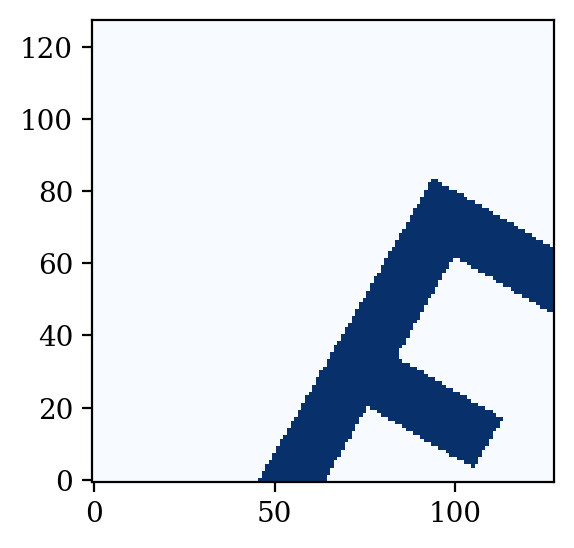

In [12]:
theta = np.pi / 6
transform_mtx = np.array([
    [np.cos(theta), -np.sin(theta), 0],
    [np.sin(theta), np.cos(theta), 0],
    [0, 0, 1]
])
try:
    for dest_y in range(dest.shape[0]):
        for dest_x in range(dest.shape[1]):
            src_x, src_y, _ = transform_mtx @ [dest_x, dest_y, 1]
            # round to integer pixels
            src_x, src_y = round(src_x), round(src_y)
            # clamp coordinates to range [0, npix - 1]
            src_x, src_y = min(max(src_x, 0), n_pix - 1), min(max(src_y, 0), n_pix - 1)
            dest[dest_y, dest_x] = src[src_y, src_x]
    plt.imshow(dest)
except Exception as e:
    print(type(e).__name__, e)

Well, that got us past the exceptions. But there's the matter of whether you want the *image* to rotate by $\pi / 6$, and which direction should be positive. Conventionally, rotation counterclockwise from the $+x$ towards the $+y$ axis is positive. So, again, we negate the value in the transformation matrix:


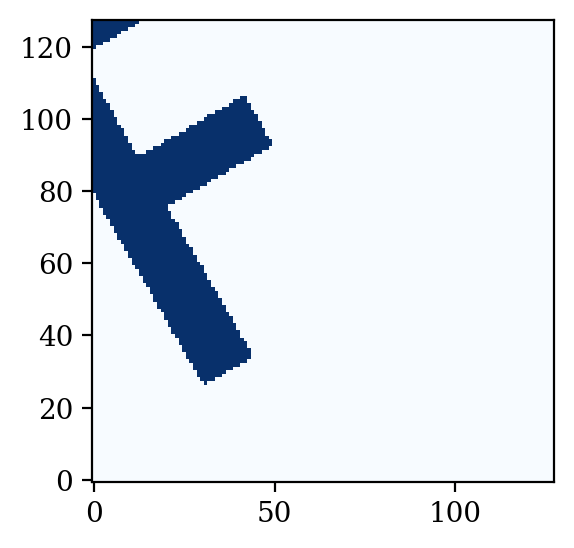

In [13]:
theta = np.pi / 6
transform_mtx = np.array([
    # n.b. rotating by -theta so image rotates +theta CCW
    [np.cos(-theta), -np.sin(-theta), 0],
    [np.sin(-theta), np.cos(-theta), 0],
    [0, 0, 1]
])

for dest_y in range(dest.shape[0]):
    for dest_x in range(dest.shape[1]):
        src_x, src_y, _ = transform_mtx @ [dest_x, dest_y, 1]
        # round to integer pixels
        src_x, src_y = round(src_x), round(src_y)
        # clamp coordinates to range [0, npix - 1]
        src_x, src_y = min(max(src_x, 0), n_pix - 1), min(max(src_y, 0), n_pix - 1)
        dest[dest_y, dest_x] = src[src_y, src_x]
plt.imshow(dest)


Better! Let's wrap that into a function.

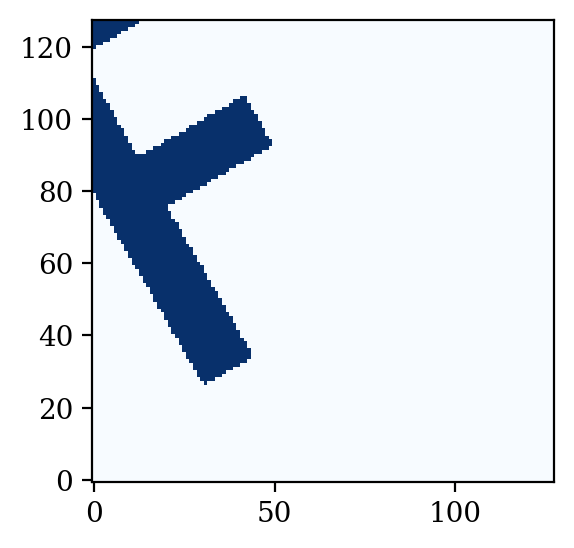

In [14]:
def simple_image_xform(src, dest_shape, transform_mtx):
    dest = np.zeros(dest_shape)
    n_pix_y, n_pix_x = src.shape
    for dest_y in range(dest.shape[0]):
        for dest_x in range(dest.shape[1]):
            src_x, src_y, _ = transform_mtx @ [dest_x, dest_y, 1]
            # round to integer pixels
            src_x, src_y = round(src_x), round(src_y)
            # clamp coordinates to range [0, npix - 1]
            src_x, src_y = min(max(src_x, 0), n_pix_x - 1), min(max(src_y, 0), n_pix_y - 1)
            dest[dest_y, dest_x] = src[src_y, src_x]
    return dest

theta = np.pi / 6
transform_mtx = np.array([
    # n.b. rotating by -theta so image rotates +theta CCW
    [np.cos(-theta), -np.sin(-theta), 0],
    [np.sin(-theta), np.cos(-theta), 0],
    [0, 0, 1]
])
plt.imshow(simple_image_xform(src, src.shape, transform_mtx))

Looks the same, which we expected. But, if you expected the F to rotate nicely about the center, you're probably disappointed. The explanation is hinted at by the ticks on the coordinate axes: the origin is pixel (0, 0), so we're pivoting about that.

For my applications, it's more useful to have a rotation about the center. Let's construct one. First, some helper functions so we don't have to write out the transform matrices by hand.

In [15]:
def rotate_image(theta_rad: float) -> np.ndarray:
    '''Transform matrix taking [x, y, 1] -> [x', y', 1] where (x', y') are
    rotated CW by theta so an image gets rotated CCW'''
    return np.array([
        [np.cos(-theta_rad), -np.sin(-theta_rad), 0],
        [np.sin(-theta_rad), np.cos(-theta_rad), 0],
        [0, 0, 1]
    ])

In [16]:
def translate_image(dx: float, dy: float) -> np.ndarray:
    '''Transform matrix taking [x, y, 1] -> [x - dx, y - dy, 1]
    so that an image feature at (x, y) is translated to (x + dx, y + dy)'''
    return np.array([
        [1, 0, -dx],
        [0, 1, -dy],
        [0, 0, 1]
    ])

In [17]:
def scale_image(sx: float, sy: float) -> np.ndarray:
    '''Transform matrix taking [x, y, 1] -> [x / sx, y / sy, 1]
    so that an image feature at (x, y) is scaled to (sx * x, sy * y)'''
    return np.array([
        [1/sx, 0, 0],
        [0, 1/sy, 0],
        [0, 0, 1]
    ])

In [18]:
def center_x_y(im_shape: tuple[int, int]) -> tuple[float, float]:
    '''Pixel coordinates for the center of `im` in (x, y) order'''
    return (im_shape[1] - 1) / 2, (im_shape[0] - 1) / 2

Now we can perform a rotation about the center as a combination of three steps: move center to origin, perform rotation about origin, move origin to image center.

Note that we want to support destination images that aren't the same dimensions as the source image, so we need the shapes of both the source and destination images. (The translation amounts are different for the centers of the source and the destination images.)


In [19]:
dest_shape = (2 * n_pix, 2 * n_pix)

### Step 1: move the image's center to the origin

Equivalently, transform the pixel coordinates of the destination such that (0, 0) maps to the source image's center.

In [20]:
cx_src, cy_src = center_x_y(src.shape)

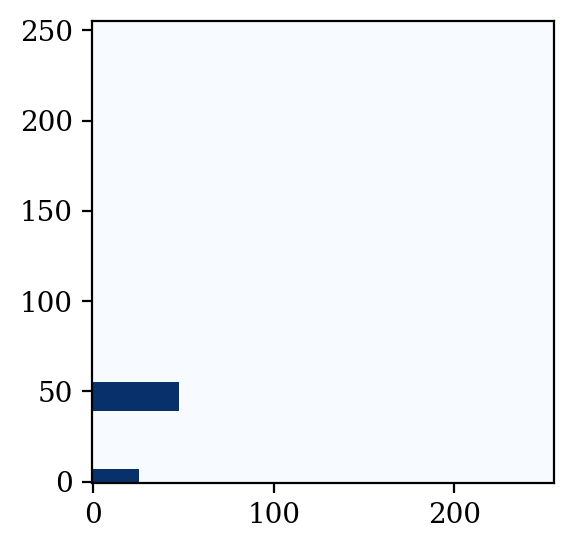

In [21]:
plt.imshow(simple_image_xform(src, dest_shape, translate_image(-cx_src, -cy_src)))

### Step 2: apply rotation

Here we see the power of composable transformations through matrix products. By multiplying the affine transformation matrices together we can chain together image operations. However, note that the order matters, and we're transforming **coordinates** and not **images**. That means for our destination pixels to be a rotated view of the source, we **de-** rotate first, then translate.

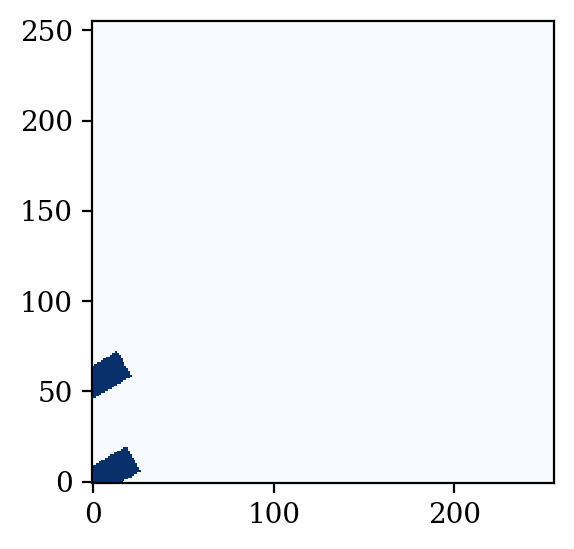

In [22]:
transform_mtx = translate_image(-cx_src, -cy_src) @ rotate_image(np.pi / 6)
plt.imshow(simple_image_xform(src, dest_shape, transform_mtx))

### Step 3: move the origin back to the center of the image

Since we have a `dest_shape` that's double the size of the source image, we translate to **its** center rather than simply undoing the original translation.

In [23]:
cx_dest, cy_dest = center_x_y(dest_shape)

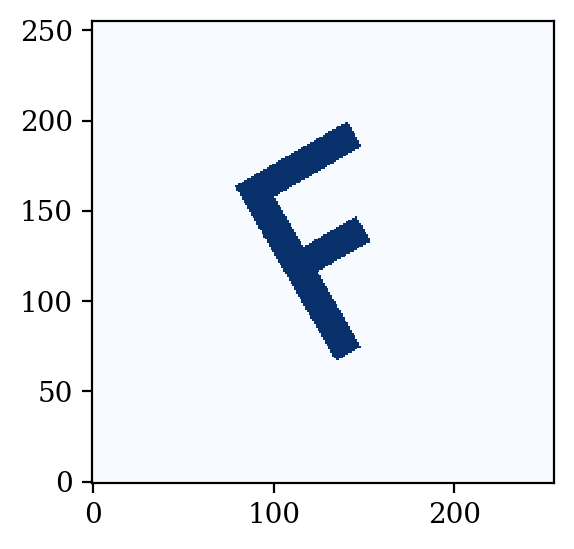

In [24]:
transform_mtx = (
    translate_image(-cx_src, -cy_src) @
    rotate_image(np.pi / 6) @
    translate_image(cx_dest, cy_dest)
)
plt.imshow(simple_image_xform(src, dest_shape, transform_mtx))

Then, we can put this all together in a helper function. 

In [25]:
def rotate_about_center(src_shape, dest_shape, theta_rad):
    '''Transform matrix taking [x, y, 1] -> [x', y', 1] where (x', y') are
    rotated CW by theta so an image gets rotated CCW about
    its center (rather than the origin)'''
    cx_src, cy_src = center_x_y(src_shape)
    cx_dest, cy_dest = center_x_y(dest_shape)
    return (translate_image(-cx_src, -cy_src) @
            rotate_image(theta_rad) @
            translate_image(cx_dest, cy_dest))

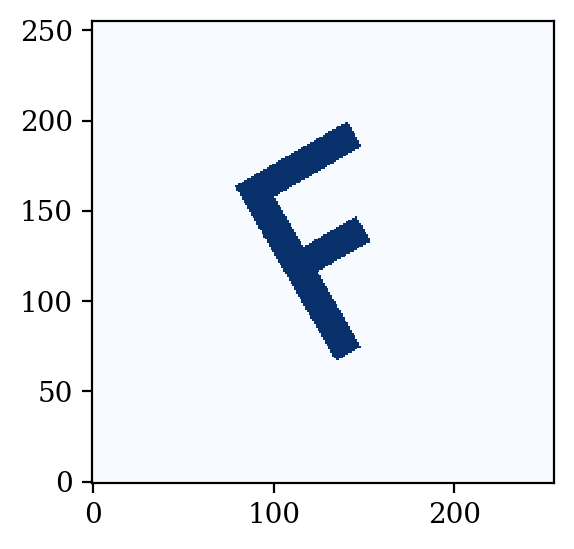

In [26]:
plt.imshow(simple_image_xform(
    src, dest_shape,
    rotate_about_center(src.shape, dest_shape, np.pi / 6)
))

The same applies to scaling, so let's make a function that does both

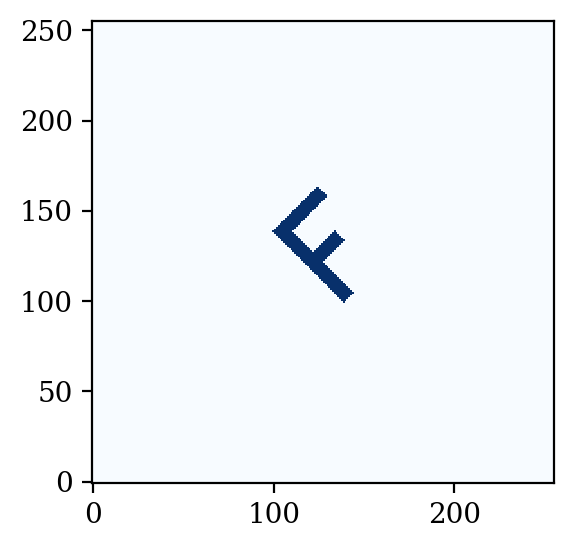

In [27]:
def rotate_and_scale_about_center(src_shape, dest_shape, sx=1.0, sy=1.0, theta_rad=0.0):
    '''Transform matrix taking [x, y, 1] -> [x', y', 1]
    so that an image is scaled from its center (rather than the origin) and rotated CCW by theta'''
    cx_src, cy_src = center_x_y(src_shape)
    cx_dest, cy_dest = center_x_y(dest_shape)
    return (
        translate_image(-cx_src, -cy_src) @ 
        rotate_image(theta_rad) @ 
        scale_image(sx, sy) @ 
        translate_image(cx_dest, cy_dest)
    )
plt.imshow(simple_image_xform(
    src, dest_shape,
    rotate_and_scale_about_center(src.shape, dest_shape, sx=0.5, sy=0.5, theta_rad=np.pi/4)
))

Using the destination shape argument we can upscale images to a higher resolution:

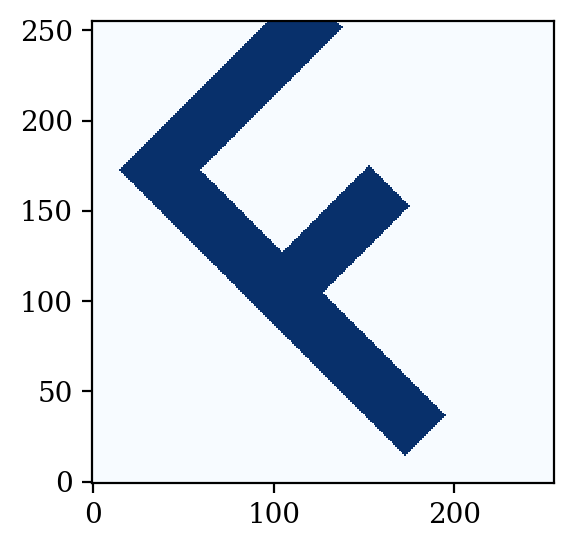

In [28]:
plt.imshow(simple_image_xform(
    src, dest_shape,
    rotate_and_scale_about_center(src.shape, dest_shape, sx=2, sy=2, theta_rad=np.pi/4)
))

## Bilinear: more sophisticated interpolation

I said above that nearest-neighbor interpolation works best when there are large regions of the same value, which is certainly true of the F test image. Let's see a less-cooperative example. Here I have plotted $f(r) = \sin(5 \pi r)$.

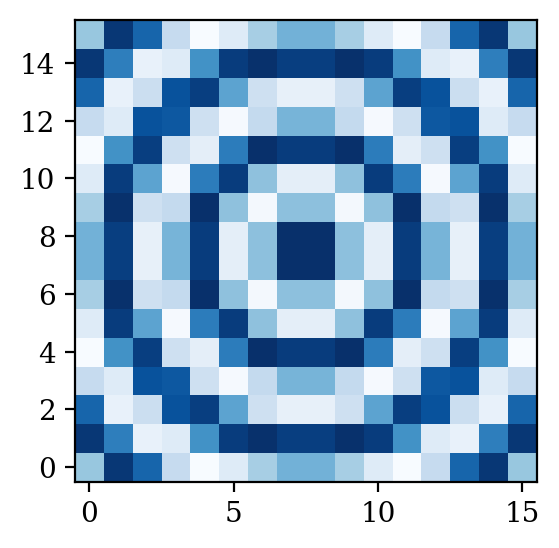

In [29]:
ex_n_pix = 16
ex = np.zeros((ex_n_pix, ex_n_pix))
xx, yy = np.meshgrid(np.linspace(-1, 1, num=ex_n_pix), np.linspace(-1, 1, num=ex_n_pix))
rr = np.hypot(yy, xx)
ex = np.sin(5 * np.pi * rr)
plt.imshow(ex)

The underlying function is clearly radially symmetric, so rotating it shouldn't change it--except that we've discretized it on a grid of pixels.

For fun, let's rotate it through $2\pi$ in angle and see if it differs from the input.

In [30]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# Create a figure and axis
fig, axs = plt.subplots(ncols=3, figsize=(6, 1.5), layout='constrained')
# Use three panels to show original, transformed, and the difference
axs[0].imshow(ex)
output = axs[1].imshow(ex)
diff = axs[2].imshow(np.zeros_like(ex), vmin=-1, vmax=1, cmap='RdBu_r')
fig.colorbar(diff)

frames_per_2pi = 32
interval_ms = 200

# Rotate by 1 / frames_per_2pi of a turn per frame
def update(frame):
    transform_mtx = rotate_and_scale_about_center(
        ex.shape, (ex_n_pix, ex_n_pix),
        1, 1, np.pi * 2 * frame / frames_per_2pi
    )
    out_image = simple_image_xform(ex, (ex_n_pix, ex_n_pix), transform_mtx)
    output.set_data(out_image)
    diff.set_data(out_image - ex)
    return [output, diff]

# Create the animation
ani = FuncAnimation(fig, update, frames=frames_per_2pi, interval=interval_ms, blit=True)

# Embed animation in notebook,
plt.close(fig)
HTML(ani.to_jshtml())


Well, that's unsastisfactory. We need to level up our interpolation function.

The simplest nontrivial interpolation function is **bilinear**, which takes the values at the four nearest pixels and interpolates three times.

Let us suppose (without loss of generality) there are only four pixels in the image, and we're trying to interpolate a value in between them. Then for the hypothetical continuous function $f(x, y)$ we only have known values for $f(0, 0)$, $f(0, 1)$, $f(1, 0)$, and $f(1, 1)$. We are looking for an approximate value for $f(\Delta x, \Delta y)$, where $0 \le \Delta x \le 1$ and $0 \le \Delta y \le 1$.

In the figure below, the known values at the source image pixel locations are shown by the red circular markers. Using the pair of points $f(0, 0)$ and $f(0, 1)$ to define a line, we can interpolate an approximate value for $f(\Delta x, 0)$ by assuming it lies on this line.


![Figure showing the four corner pixel values used for bilinear interpolation](../../static/figures/interpolation/bilinear_interpolation.svg)

Linearly interpolating gives $f(\Delta x, 0) \approx f(0, 0) (1 - \Delta x) +  f(1, 0)(\Delta x)$, the value at the lower square marker. 

Repeating the procedure with $f(1, 0)$ and $f(1, 1)$ gives us an approximation for $f(\Delta x, 1) \approx f(1, 0) (1 - \Delta x) +  f(1, 1)(\Delta x)$, shown by the upper square marker. 

Finally, we interpolate between $f(\Delta x, 0)$ and $f(\Delta x, \Delta y)$ to get the interpolated value for our destination pixel:
\begin{align*}
f(\Delta x, \Delta y) \approx&\ f(\Delta x, 0) (1 - \Delta y) +  f(\Delta x, 1)(\Delta y)\\
=&\ (f(0, 0) (1 - \Delta x) +  f(1, 0)(\Delta x)) (1 - \Delta y) + (f(1, 0) (1 - \Delta x) +  f(1, 1)(\Delta x))(\Delta y)\\
=&\ f(0, 0) (1 - \Delta x) (1 - \Delta y)\\
&\ +\ f(1, 0) (\Delta x) (1 - \Delta y)\\
&\ +\ f(1, 0) (1 - \Delta x) (\Delta y)\\
&\ +\ f(1, 1)(\Delta x)(\Delta y)
\end{align*}

We only work this out for the case where we're in the first pixel in the grid because we can always choose our coordinates such that we are there. Let's make a function to do this calculation, cutting out the $2 \times 2$ pixels we care about from the source image.

In [31]:
def bilinear_patch(src, x, y):
    max_y = src.shape[0] - 1
    max_x = src.shape[1] - 1
    int_x, int_y = int(x), int(y)
    # if the integer part == the max, this is an edge pixel
    # and interpolation will need pixels beyond the source image edge
    if int_x >= max_x or int_y >= max_y:
        return np.nan
    # if the integer part < 0, this is an edge pixel
    if int_x < 0 or int_y < 0:
        return np.nan
    # otherwise, dx and dy account for the fractional part of the pixel coord
    dx, dy = x - int(x), y - int(y)
    # the relevant pixels are the four corners of the box containing (x, y)
    patch = src[int_y:int_y + 2,int_x:int_x + 2]
    return (
        patch[0, 0] * (1 - dx) * (1 - dy) +
        patch[0, 1] * dx * (1 - dy) +
        patch[1, 0] * (1 - dx) * dy +
        patch[1, 1] * dx * dy
    )

The comments point out the places where we handle out-of-bounds coordinates by returning not-a-number (a.k.a. NaN or `np.nan`).

Updating the `simple_image_xform` function to use `bilinear_patch` to find the destination pixel values, we have `bilinear_image_xform`:

In [32]:

def bilinear_image_xform(src, dest_shape, transform_mtx):
    dest = np.zeros(dest_shape)
    for dest_y in range(dest.shape[0]):
        for dest_x in range(dest.shape[1]):
            src_x, src_y, _ = transform_mtx @ [dest_x, dest_y, 1]
            dest[dest_y, dest_x] = bilinear_patch(src, src_x, src_y)
    return dest

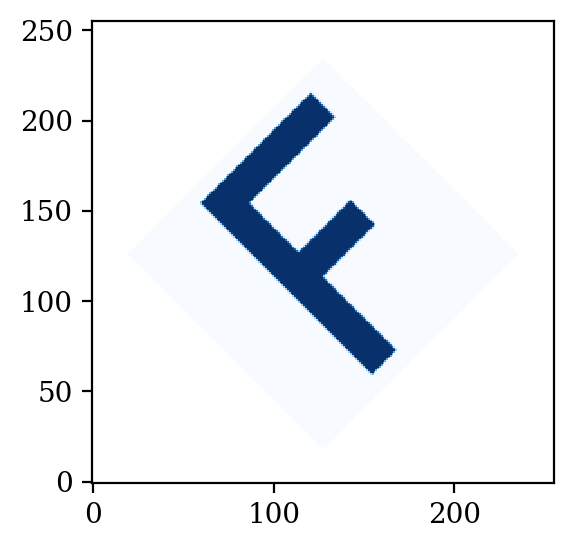

In [33]:
plt.imshow(bilinear_image_xform(src, dest_shape, rotate_and_scale_about_center(src.shape, dest_shape, 1.2, 1.2, np.pi / 4)))

In [34]:
fig, axs = plt.subplots(ncols=3, figsize=(6, 1.5), layout='constrained')
# Use three panels to show original, transformed, and the difference
axs[0].imshow(ex, vmin=-1, vmax=1)
output = axs[1].imshow(ex, vmin=-1, vmax=1)
diff = axs[2].imshow(np.zeros_like(ex), vmin=-1, vmax=1, cmap='RdBu_r')
fig.colorbar(diff)

# Rotate by 1 / frames_per_2pi of a turn per frame
def update(frame):
    transform_mtx = rotate_and_scale_about_center(
        ex.shape, (ex_n_pix, ex_n_pix),
        1, 1, np.pi * 2 * frame / frames_per_2pi
    )
    out_image = bilinear_image_xform(ex, (ex_n_pix, ex_n_pix), transform_mtx)
    output.set_data(out_image)
    diff.set_data(out_image - ex)
    return [output, diff]

# Create the animation
ani = FuncAnimation(fig, update, frames=frames_per_2pi, interval=500, blit=True)

# Embed animation in notebook
plt.close(fig)
ani.save('./anim.mp4')
HTML(ani.to_jshtml())

Two things (again) to notice here:

### Improved residuals

We can tell we're doing better because the residuals (rightmost panel) are smaller on average than in the nearest-neighbor example above. So, even though the image looks different up close, we're getting closer to the ideal (i.e. rotational symmetry).

### Missing pixels

From the very first frame, there is one row and one column that are white (i.e. missing). The destination pixel no longer depends on just one source pixel; we need a little domain of four pixels. 

On frame zero, we're rotating by 0º, which shouldn't change anything. However, for an $N \times N$ image, the corner pixel at $(N - 1, N - 1)$ will depend on values in pixels $(N - 1, N)$, $(N, N - 1)$, and $(N, N)$. Of course, those values are unknown (or unknowable), so the result of the interpolation is undefined.

There are various reasonable workarounds, like checking if the transformation maps to an integer coordinate in the source image and skipping the whole interpolation step. Another option is to replace the missing values in the `bilinear_patch` calculation with the nearest known values. Both are justifiable, but you should know which one you're doing so that you don't get confused by interpolation artifacts.

## Bicubic interpolation or cubic convolution: best speed/accuracy tradeoff

Bilinear interpolation assumes the underlying continuous function sampled on our pixel grid increases or decreases only linearly in the space between pixels. Of course, we know plenty of functions without constant first derivatives. Can we capture some of this higher order behavior? The answer is yes, at the cost of some complexity and additional arithmetic operations.

With a carefully chosen kernel function, a $4 \times 4$ domain of pixels can contribute to a cubic curve that connects two of the pixels. (This is not quite [spline interpolation](https://en.wikipedia.org/wiki/Spline_interpolation), but a good approximation that doesn't require derivative information for the underlying function.)

To implement bicubic interpolation let's start with an example image. The `mini_img` below is a $4 \times 4$ image covering the region $-1 \le x \le 2$ and $-1 \le y \le 2$.

(Nearest-neighbor uses one pixel, bilinear uses $2 \times 2$ pixels, and bicubic uses $4 \times 4$. Why doesn't anyone use $3 \times 3$, for biquadratic? Well... that's kind of complicated.)

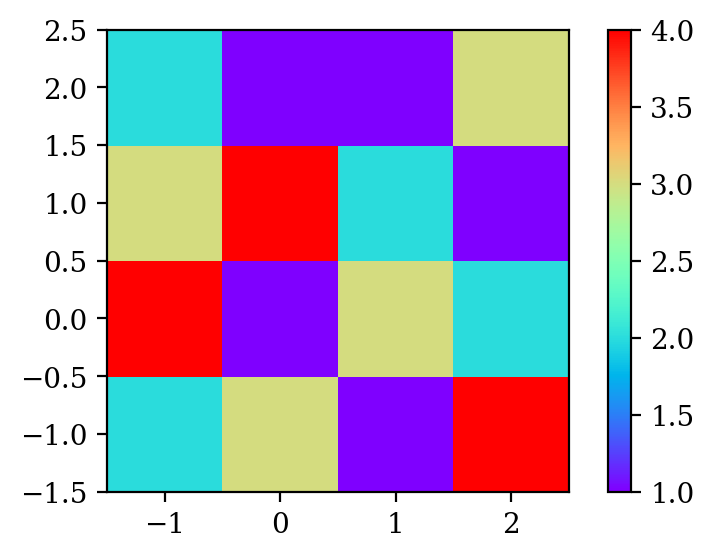

In [35]:
from matplotlib import colors
cmap = plt.cm.rainbow.copy()
norm = colors.Normalize(vmin=1, vmax=4)
mini_img = np.array([
    [2, 3, 1, 4],
    [4, 1, 3, 2],
    [3, 4, 2, 1],
    [2, 1, 1, 3],
])
pixel_colors2 = cmap(norm(mini_img.flat)).reshape(2, 2, -1)
plt.imshow(mini_img, cmap=cmap, origin='lower', extent=[-1.5, 2.5, -1.5, 2.5])
plt.colorbar()

If we use the 1D cubic convolution kernel to interpolate values between columns, we get four continuous curves representing $f(x, -1)$, $f(x, 0)$, $f(x, 1)$, $f(x, 2)$, one for each row.

As above with bilinear interpolation, we are assuming (without loss of generality) that we are interpolating coordinates in the domain $0 < \Delta x < 1$ and $0 < \Delta y < 1$. Evaluating these approximations at $x = \Delta x$ for each gives us four new values, $f(\Delta x, -1)$, $f(\Delta y, 0)$, $f(\Delta y, 1)$, $f(\Delta y, 2)$.

Plugging these into the same 1D interpolation function allows us to approximate $f(\Delta x, \Delta y)$.

This (somewhat complicated) figure shows what's going on.

![Figure showing the bicubic interpolation procedure first by column, then by row](../../static/figures/interpolation/bicubic_interpolation.svg)

First, each row is interpolated at $\Delta x$, shown as smaller circular points between 0 and 1. The curve connecting $y = 0$ to $y = 1$ is then evaluated at $y = \Delta y$ to get an approximate value for $f(\Delta x, \Delta y)$.

What's the magic kernel function, then? It was derived by one Robert G. Keys in a 1981 publication ("Cubic convolution interpolation for digital image processing", IEEE Transactions on Acoustics, Speech, and Signal Processing). It's not even that hard to follow if you have some knowledge of Taylor series and algebra.

(Unfortunately, as of this writing IEEE is still trying to charge $33.00 for access to a paper that's more than four decades old. So you'll have to [find it on your own](https://scholar.google.com/scholar?cluster=5401038052747489855&hl=en&as_sdt=0,33).)

The interpolation kernel is

$$
    u(s) = \begin{cases}
        \frac{3}{2} |s|^3 - \frac{5}{2} |s|^2 + 1           & 0 < |s| < 1\\
        -\frac{1}{2} |s|^3 + \frac{5}{2} |s|^2 - 4 |s| + 2  & 1 < |s| < 2\\
        0                                                   & s < |s|
    \end{cases}
$$

which, with some algebraic manipulation given in the paper, can produce the interpolation function $g(x) \approx f(x)$ which can be evaluated to approximate $f(x)$ between samples. The interpolation function is

\begin{align*}
    g(x) =&\ c_{k - 1} (- s^3 + 2 s^2 - s)/2 + c_k (3s^3 - 5s^2 + 2)/2\\
           &+ c_{k + 1} (-3 s^3 + 4s^2 + s)/2 + c_{k + 2}(s^3 - s^2)/2
\end{align*}

where $s = (x - x_k) / h$, $h$ is the sampling interval, and $c_k = f(x_k)$ for $k = 0, 1, 2, ..., N$ are the known sample values at the coordinates $x_k$.

We've set up the coordinates above to run from -1 to 2, and we're using pixel coordinates so $h = 1$ and can be neglected. Therefore $s = \Delta x$ and $c_{k - 1} = f(-1)$, $c_{k} = f(0)$, and so on. 

(Note: Here we're making a slight abuse of notation, since we're interpolating in 1D: $f(x)$ is really $f(x, y)$ for some sampled y coordinate.)

The simplified expression for our chosen coordinates becomes

\begin{align*}
    g(x) = &f(-1) \frac{-(\Delta x)^3 + 2(\Delta x)^2 - (\Delta x)}{2}\\
           &+ f(0) \frac{3(\Delta x)^3 - 5(\Delta x)^2 + 2}{2}\\
           &+ f(1) \frac{-3(\Delta x)^3 + 4(\Delta x)^2 + \Delta x}{2}\\
           &+ f(2) \frac{(\Delta x)^3 - (\Delta x)^2}{2}
\end{align*}

We then factor out the 1/2 and group terms by powers of $\Delta x$:

\begin{align*}
g(x) = \frac{1}{2} [ &\left[-f(-1) + 3f(0) - 3f(1) + f(2)\right] (\Delta x)^3 \\
                          &+ \left[ 2f(-1) - 5f(0) + 4f(1) - f(2)\right] (\Delta x)^2 \\
                          &+ \left[ -f(-1) + f(1) \right] (\Delta x)\\
                          &+ 2f(0)
                    ]
\end{align*}

which we can translate to Python code:

In [36]:
def cubic1d(t, f_minus1, f_0, f_1, f_2):
    a = 2 * f_0
    b = -1 * f_minus1 + f_1
    c = 2 * f_minus1 - 5 * f_0 + 4 * f_1 - f_2
    d = -1 * f_minus1 + 3 * f_0 - 3 * f_1 + f_2
    return 0.5 * (a + t * b + t ** 2 * c + t ** 3 * d)

Now let's interpolate $f(\Delta x, \Delta y)$ in the image above for some values of $\Delta x$ and $\Delta y$.

In [37]:
delta_x, delta_y = 0.5, 0.5

The interpolation curve from `cubic1d` should pass through $f(0, y)$ and $f(1, y)$ when we evaluate it on the interval $0 < x < 1$.

[Text(0.5, 0, 'x'), (-1.5, 2.5), (0.0, 5.0)]

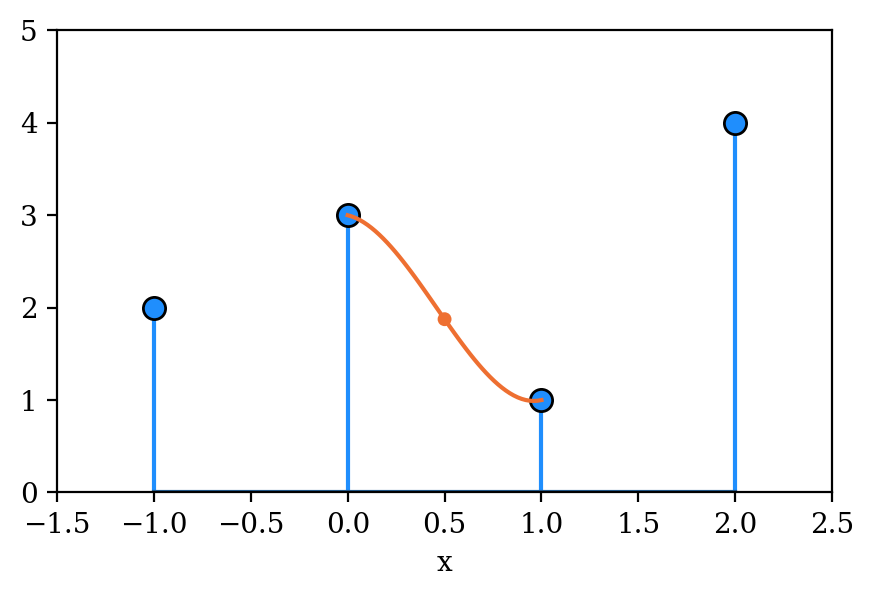

In [38]:
coords = np.linspace(0, 1)

fig, ax = plt.subplots()
markers, _, _ = ax.stem(np.arange(-1, 3), mini_img[0])
markers.set_markersize(8)
markers.set_markeredgecolor('k')
# interpolate along 0 < y < 1
interp_curve = cubic1d(
    coords,
    mini_img[0, 0], mini_img[0, 1], mini_img[0, 2], mini_img[0, 3]
)
ax.plot(coords, interp_curve, c='C1')
# interpolate just at ∆x
val = cubic1d(
    delta_x,
    mini_img[0, 0], mini_img[0, 1], mini_img[0, 2], mini_img[0, 3]
)
ax.scatter(delta_x, val, s=100, marker='.', fc='C1', ec='none')
ax.set(xlabel='x', xlim=(-1.5, 2.5), ylim=(0, 5))

This shows the interpolated value for $f(\Delta x, 0)$ as an orange dot on the curve. (Why not draw a curve through all three pairs? Well, you need a domain of $4 \times 4$ pixels, so we'd need one more pixel on the "low" side and two more on the "high" side.)

To make this 2D we repeat for every row of the image:

[Text(0.5, 0, 'x'), (-1.5, 2.5), (0.0, 5.0)]

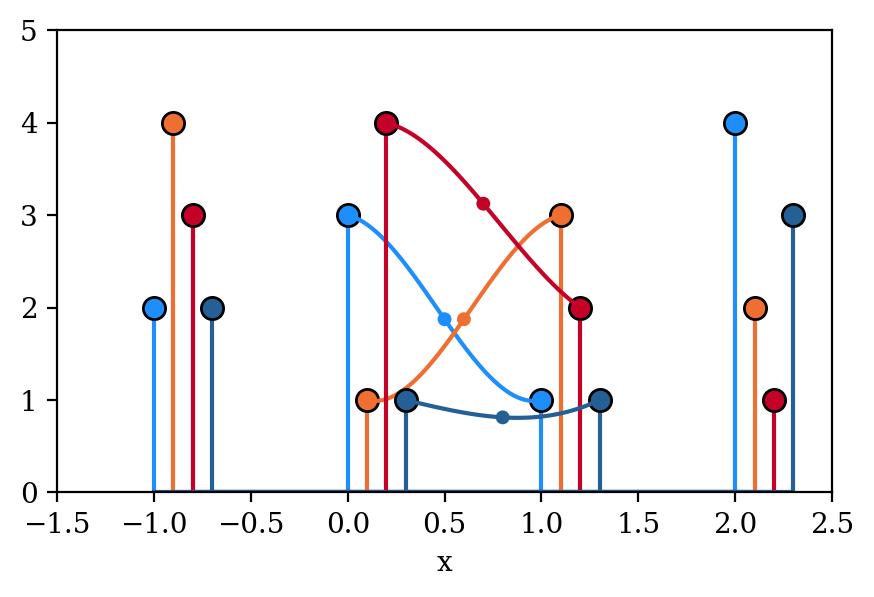

In [39]:
interpolated_values = []
fig, ax = plt.subplots(figsize=(5, 3))

for i in range(4):
    offset = i / 10
    markers, _, _ = ax.stem(
        np.arange(-1, 3) + offset, mini_img[i],
        markerfmt=f'C{i}', linefmt=f'C{i}'
    )
    markers.set_markersize(8)
    markers.set_markeredgecolor('k')
    # interpolate along 0 < y < 1
    interp_curve = cubic1d(
        coords,
        mini_img[i, 0], mini_img[i, 1], mini_img[i, 2], mini_img[i, 3]
    )
    ax.plot(coords + offset, interp_curve, c=f'C{i}')
    # interpolate just at ∆x
    val = cubic1d(
        delta_x,
        mini_img[i, 0], mini_img[i, 1], mini_img[i, 2], mini_img[i, 3]
    )
    interpolated_values.append(val)
    ax.scatter(delta_x + offset, val, s=100, marker='.', ec='none', fc=f'C{i}')

ax.set(xlabel='x', xlim=(-1.5, 2.5), ylim=(0, 5))

Above, we've plotted the values from the different rows offset slightly for clarity.

Taking the interpolated values for $f(\Delta x, y)$ for $y = -1, 0, 1, 2$ (shown by the point markers on the interpolated curves above) as a new 1D sequence, we interpolate again:

[Text(0, 0.5, 'y'), (-1.5, 2.5), (0.0, 5.0)]

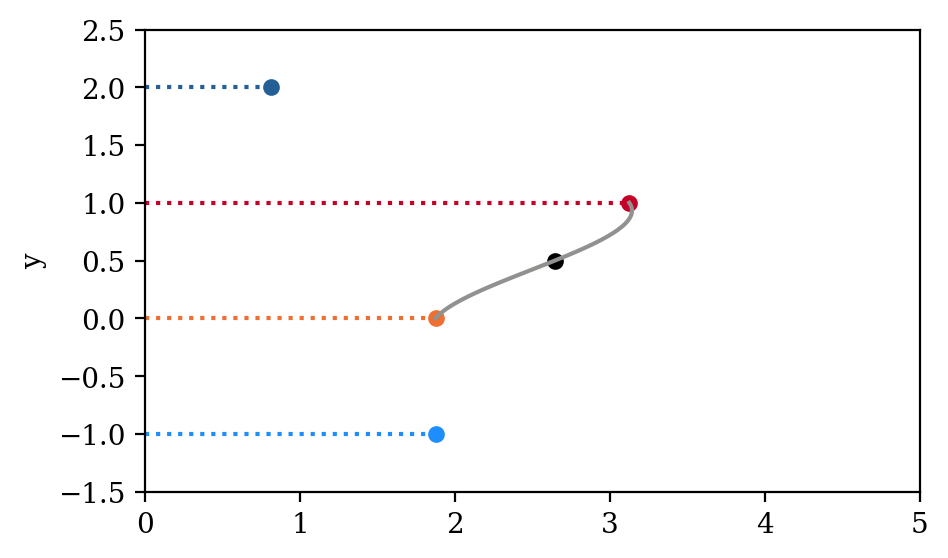

In [40]:
fig, ax = plt.subplots()
for v, y in zip(interpolated_values, np.arange(-1, 3)):
    ax.scatter(v, y, marker='.', s=100)
    ax.plot([0, v], [y, y], ls=':')

ax.plot(cubic1d(np.linspace(0, 1), *interpolated_values), coords)

val = cubic1d(delta_y, *interpolated_values)
ax.scatter(val, delta_y, s=100, marker='.', fc='k')

ax.set(ylabel='y', ylim=(-1.5, 2.5), xlim=(0, 5))

This interpolation along a second direction is the "bi" in bicubic. We can write it up as a function that assumes a 4 x 4 pixel subimage to operate on.

In [41]:
def bicubic(dx, dy, region):
    # Perform 4 1D interpolations by dx along the rows of region
    b_minus1 = cubic1d(dx, region[0, 0], region[0, 1], region[0, 2], region[0, 3])
    b_0 = cubic1d(dx, region[1, 0], region[1, 1], region[1, 2], region[1, 3])
    b_1 = cubic1d(dx, region[2, 0], region[2, 1], region[2, 2], region[2, 3])
    b_2 = cubic1d(dx, region[3, 0], region[3, 1], region[3, 2], region[3, 3])
    # perform 1 interpolation by dy along the column of b values
    interpolated_value = cubic1d(dy, b_minus1, b_0, b_1, b_2)
    return interpolated_value


The interpolated $f(\Delta x, \Delta y)$ should agree, and it does:

[Text(0, 0.5, 'y'), (-1.5, 2.5), (0.0, 5.0)]

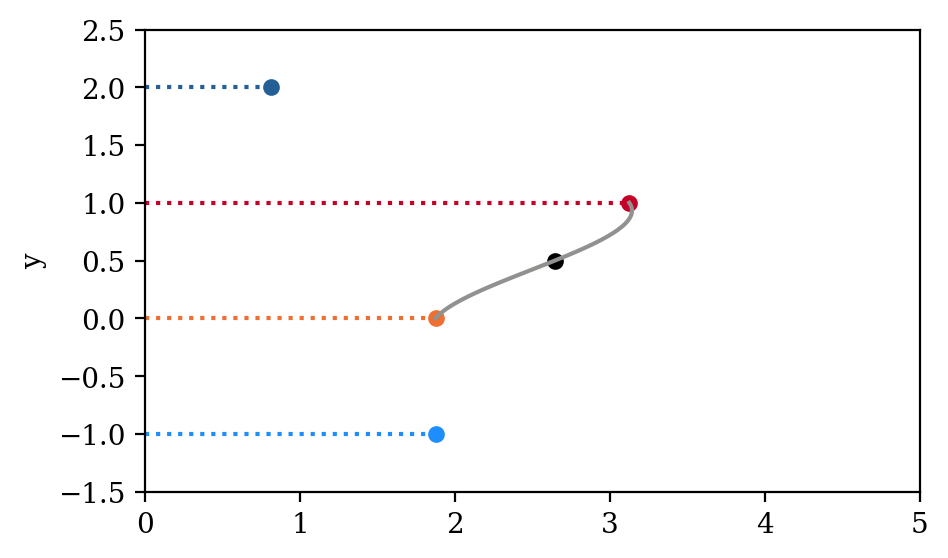

In [42]:
fig, ax = plt.subplots(figsize=(5, 3))
# ax.stem(np.arange(-1, 3), interpolated_values, orientation='horizontal')
for v, y in zip(interpolated_values, np.arange(-1, 3)):
    ax.scatter(v, y, marker='.', s=100)
    ax.plot([0, v], [y, y], ls=":")

ax.plot(cubic1d(np.linspace(0, 1), *interpolated_values), coords)

ax.scatter(bicubic(delta_x, delta_y, mini_img), delta_y, s=100, marker='.', fc='k')

ax.set(ylabel='y', ylim=(-1.5, 2.5), xlim=(0, 5))

Now, we just have to do this for every pixel in the destination image. Easy!

Since it requires a $4 \times 4$ pixel domain to interpolate from, I've restructured the code to construct a cutout image with a fill value for missing pixels (i.e. on the edges).

In [43]:
def get_or_fill(image, x, y, fill_value):
    # get image[y, x] replacing out-of-bounds pixels with `fill_value`
    if y < 0 or y >= image.shape[0]:
        return fill_value
    if x < 0 or x >= image.shape[1]:
        return fill_value
    return image[y, x]

def cutout_for_bicubic(image, src_x, src_y, fill_value):
    # construct a subframe of 4 x 4 pixels
    cutout = np.zeros((4, 4))
    for y, row in enumerate(range(-1, 3)):
        for x, col in enumerate(range(-1, 3)):
            cutout[y, x] = get_or_fill(image, src_x + col, src_y + row, fill_value)
    return cutout

def bicubic_image_xform(src, dest_shape, transform_mtx, fill_value=0.0):
    dest = np.zeros(dest_shape)
    for dest_y in range(dest.shape[0]):
        for dest_x in range(dest.shape[1]):
            src_x, src_y, _ = transform_mtx @ [dest_x, dest_y, 1]
            int_x, int_y = int(np.floor(src_x)), int(np.floor(src_y))
            region = cutout_for_bicubic(src, int_x, int_y, fill_value)
            dx, dy = src_x - int_x, src_y - int_y
            dest[dest_y, dest_x] = bicubic(dx, dy, region)
    return dest

Let's see the effect of different fill values on the resulting image. Here I'm rotating by 45º with zeros and with `np.nan`s for out-of-bounds points.

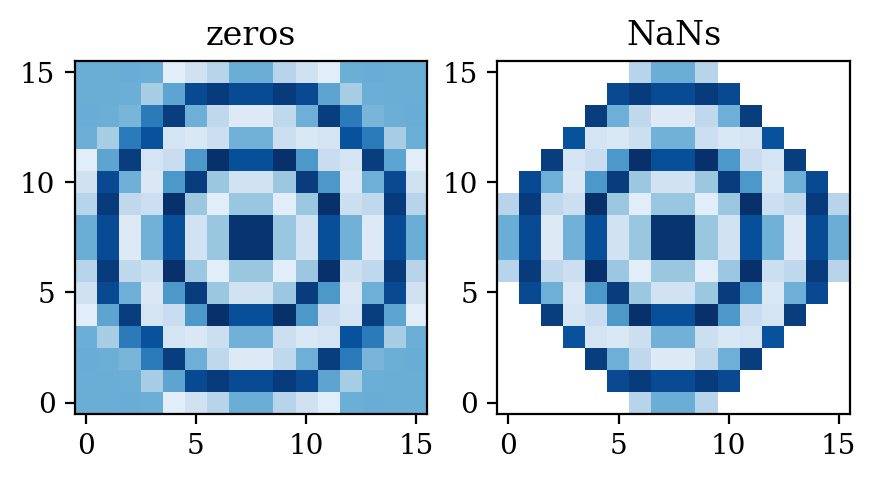

In [44]:
xform = rotate_and_scale_about_center(
    ex.shape, (ex_n_pix, ex_n_pix),
    1, 1, np.deg2rad(45)
)
fig, axs = plt.subplots(ncols=2)
axs[0].set_title('zeros')
out_image = bicubic_image_xform(ex, (ex_n_pix, ex_n_pix), xform, fill_value=0.0)
axs[0].imshow(out_image, vmin=-1, vmax=1)

axs[1].set_title('NaNs')
out_image = bicubic_image_xform(ex, (ex_n_pix, ex_n_pix), xform, fill_value=np.nan)
axs[1].imshow(out_image, vmin=-1, vmax=1)

Arguably, the interpolated values at the edges on the left are just nonsense and there for aesthetic reasons. The missing value treatment *least likely to mislead you* is to treat every computation that takes an undefined value as producing an undefined value, which is exactly what a fill value of `np.nan` does.

Let's see how it does with the radially symmetric signal.

In [45]:
fig, axs = plt.subplots(ncols=3, figsize=(6, 1.5), layout='constrained')
# Use three panels to show original, transformed, and the difference
axs[0].imshow(ex, vmin=-1, vmax=1)
output = axs[1].imshow(ex, vmin=-1, vmax=1)
diff = axs[2].imshow(np.zeros_like(ex), vmin=-1, vmax=1, cmap='RdBu_r')
fig.colorbar(diff)

# Rotate by 1 / frames_per_2pi of a turn per frame
def update(frame):
    transform_mtx = rotate_and_scale_about_center(
        ex.shape, (ex_n_pix, ex_n_pix),
        1, 1, np.pi * 2 * frame / frames_per_2pi
    )
    out_image = bicubic_image_xform(ex, (ex_n_pix, ex_n_pix), transform_mtx, np.nan)
    output.set_data(out_image)
    diff.set_data(out_image - ex)
    return [output, diff]

# Create the animation
ani = FuncAnimation(fig, update, frames=frames_per_2pi, interval=interval_ms, blit=True)

# Embed animation in notebook
plt.close(fig)
HTML(ani.to_jshtml())

Not bad! Returning to the "F" test image for a moment, let's investigte the bicubic interpolator's behavior around sharp edges. Here we translate the test pattern by a noninteger number of pixels (to make the sub-pixel behavior of the interpolator visible).

Let's zoom in on the base of the F and plot a slice through the image.

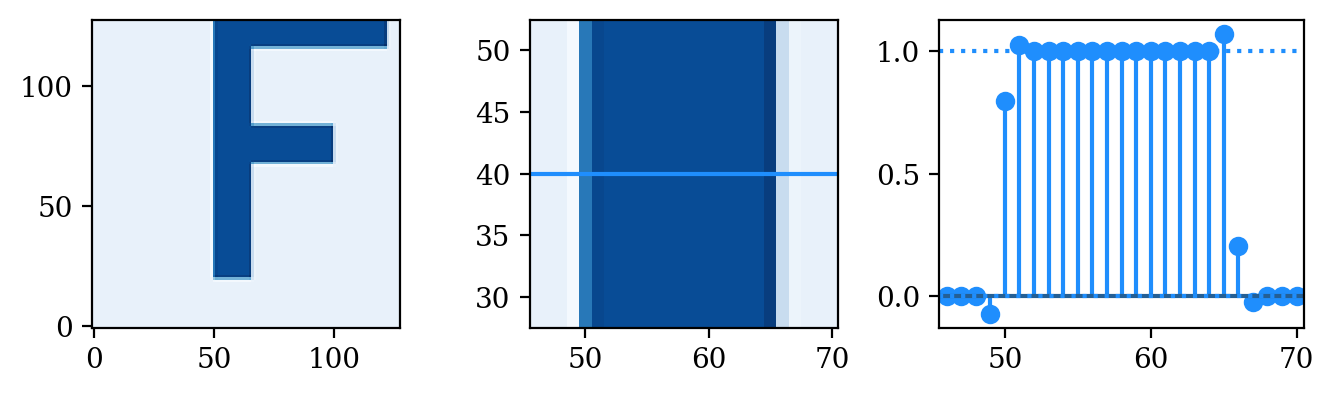

In [46]:
result = bicubic_image_xform(src, src.shape, translate_image(10.25, 12.5))

# define detail region
row_slice = 40
col_center = 58
detail_size = 25

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(8,2))

# Show translation result
ax1.imshow(result)
# Show detail
ax2.imshow(result)
ax2.axhline(row_slice)
ax2.set(
    xlim=(col_center - detail_size/2, col_center + detail_size/2),
    ylim=(row_slice - detail_size/2, row_slice + detail_size/2)
)
# Show stem plot of slice through image
ax3.stem(np.arange(result.shape[1]), result[row_slice])
ax3.set_xlim(col_center - detail_size/2, col_center + detail_size/2)
ax3.axhline(1.0, linestyle=':')
ax3.axhline(0.0, linestyle=':')

We put in ones and zeros in the test pattern, so why have we got values below zero and above one now? In the test pattern, the the edge of the "F" in the test image is a discontinuity; from one pixel to the next the value jumps from 0 to 1. Intuitively, we think that the edge should be "infinitely sharp", so the result of translation should still transition from zero to one in the space of a single pixel.

**Why is this so different from our intuition? Is this "right"?**

## Oversampling, undersampling, and band limits

This is "ringing", basically the same thing as [Gibbs phenomenon](https://en.wikipedia.org/wiki/Gibbs_phenomenon). It all boils down to what you're capturing in your pixels. If your image contains infinitely sharp edges, like our "F" example, you need an infinite number of pixels to express that in a pixelated / sampled format. So, no, the image above is not "right"; this is why graphic designers use a [completely different image representation](https://en.wikipedia.org/wiki/Vector_graphics) to work in. In practice, we have given the computer a number of samples, representing a signal up to some **band-limit** that corresponds to how finely sampled (i.e. sharp) it is.

Fortunately, if you're taking pictures of natural phenomena, there are no infinitely sharp edges. When considering the [detection of exoplanet signals](klip-in-numpy), we are dealing with a more constrained version of the image interpolation problem than, e.g., Photoshop does. In high-contrast imaging, our science images are always _oversampled_ relative to the band-limit of the telescope system. That means that we can be confident that our interpolation and resampling is preserving information (at least, to a good approximation).

Consider a counter-example: an *undersampled* image of a star might look like this:

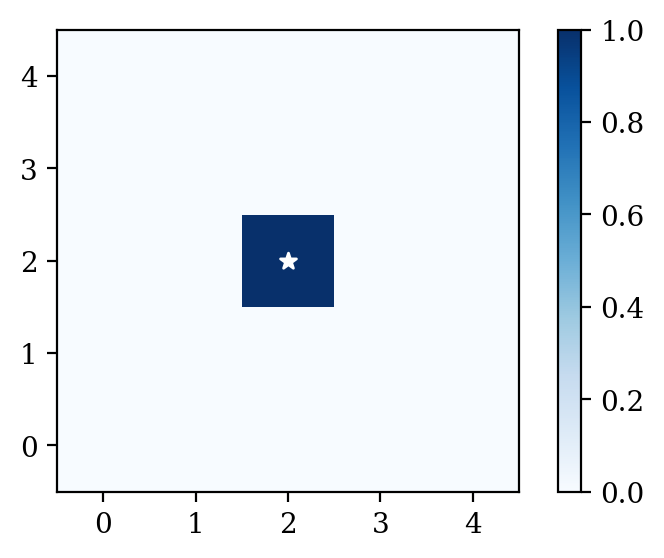

In [47]:
star = np.array([
    [0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0],
    [0, 0, 1, 0, 0],
    [0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0],
])
plt.imshow(star, vmin=0, vmax=1)
plt.scatter(2, 2, marker='*', c='w')
plt.colorbar()

Here I've marked the star location at $(2, 2)$. It might *really* be at $(2.25, 2)$, but it's such a tiny feature it gets summed up in the pixel ranging from $1.5 < x < 2.5$ and $1.5 < y < 2.5$.

What if we translate the image 0.5 pixels right, using our interpolator from above?

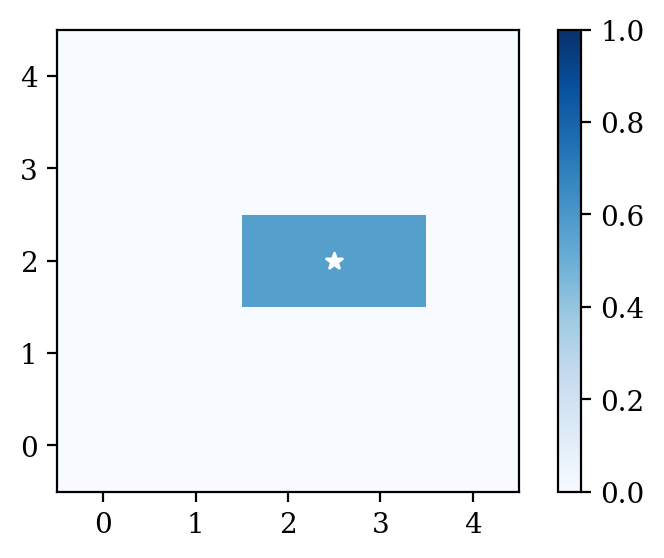

In [48]:
plt.imshow(
    bicubic_image_xform(star, star.shape, translate_image(0.5, 0)),
    vmin=0, vmax=1
)
plt.scatter(2.5, 2, marker='*', c='w')
plt.colorbar()

If your model for the "star" in pixel $(2, 2)$ is that it's illuminating one pixel-sized square uniformly from its center, shifting the square by half a pixel puts the star on the border between pixels at $(2.5, 2)$, so it is quite reasonable to put half the light in the adjacent pixel. On the other hand, if your star is really at $(2.25, 2.25)$, the star shifts to $(2.75, 2.25)$ so **more than half** of the light should be there. 

Given this transformed image, you would also be unable to tell if it is one star of brightness 1.0 on a pixel boundary, or two stars of brightness 0.5 that happen to be next to each other.

In an undersampled image, there's **no way to know.** In other words, there is no way to rotate or translate the undersampled image without introducing potentially major changes in it.

Though it's not an isolated point like a star, the hard edge of the "F" pattern is an example of one of these undersampled features.

### Oversampled scene

The most extreme case for an undersampled scene is a single pixel, but what model should we use for an oversampled scene? You won't go far wrong with a 2D Gaussian; even extreme adaptive optics PSFs are nearly Gaussian in their core.

Let's construct a 16 x 16 pixel scene with a Gaussian at the center. To compare with the interpolated image we will also generate one where the Gaussian has been displaced by `dx = 2.5` pixels. Here we're generating two "truth" images based on the true analytical expression for $f(x, y)$ (implemented as `gauss2d`).

[Text(0.5, 1.0, 'translated by dx=2.5')]

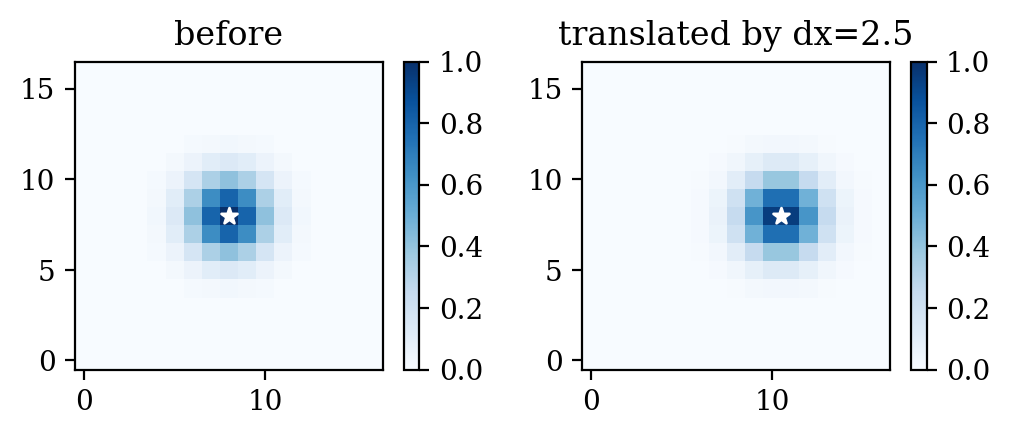

In [49]:
samples = 17
xs = np.arange(samples)
xx, yy = np.meshgrid(xs, xs)
rr = np.hypot(yy, xx)
sigma = 1.5

def gauss2d(x, y, x0, y0, amp, sigma_x, sigma_y):
    return amp * np.exp(-(
            ((x - x0)**2 / (2 * sigma_x**2))
            +
            ((y - y0)**2 / (2 * sigma_y**2))

    ))

# place Gaussian at array center
xc = yc = (samples - 1) / 2
sigma = 1.5
dx = 2.5

fig, axs = plt.subplots(ncols=2, figsize=(6, 2))
gaussian_before = gauss2d(xx, yy, xc, yc, 1, sigma, sigma)
fig.colorbar(axs[0].imshow(gaussian_before, vmax=1))
axs[0].scatter(xc, yc, marker='*', c='w')
axs[0].set(title='before')

# show scene translated by dx
gaussian_translated = gauss2d(xx, yy, xc + dx, yc, 1, sigma, sigma)
fig.colorbar(axs[1].imshow(gaussian_translated, vmax=1))
axs[1].scatter(xc + dx, yc, marker='*', c='w')
axs[1].set(title=f'translated by {dx=}')

Now we attempt to perform the translation by interpolation, using the "before" image.

In [50]:
np.sum(gaussian_before)

np.float64(14.137166708707573)

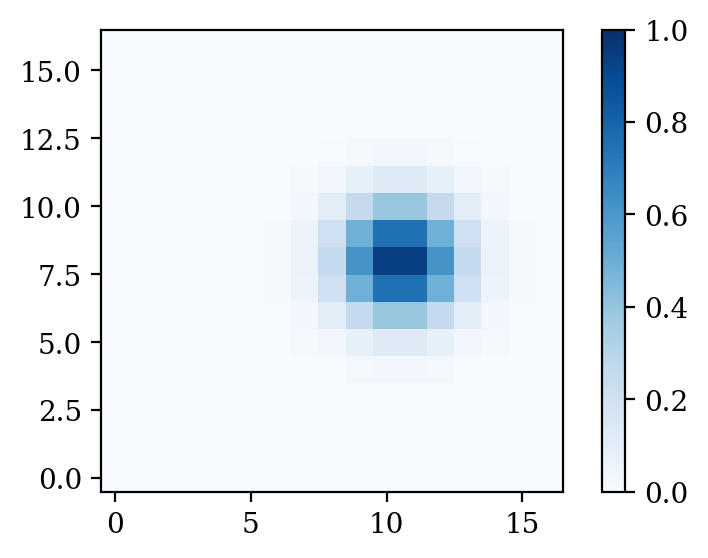

In [51]:
gaussian_translated_interp = bicubic_image_xform(
    gaussian_before, gaussian_before.shape,
    translate_image(dx, 0)
)
plt.imshow(gaussian_translated_interp, vmin=0, vmax=1)
plt.colorbar()

That is close enough to the "truth" image that it's probably easier to make sense of a plot showing their difference.

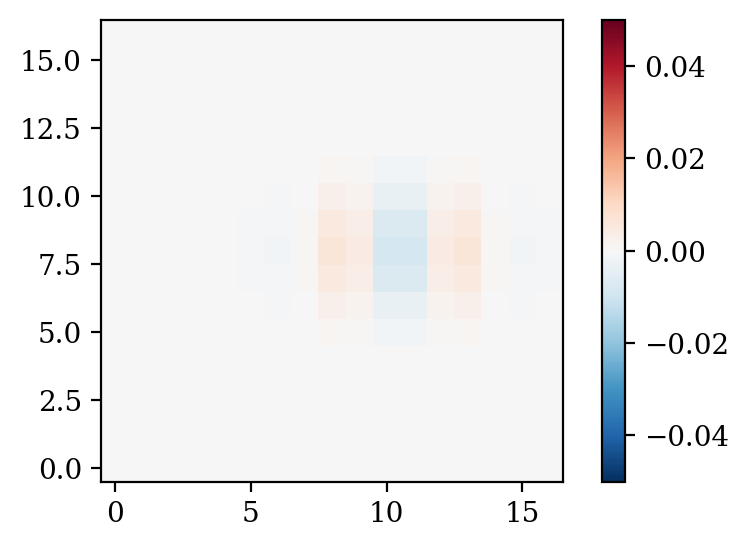

In [52]:
plt.imshow(
    (gaussian_translated_interp - gaussian_translated),
    cmap='RdBu_r', vmin=-0.05, vmax=0.05
)
plt.colorbar()

Here you can see that the bicubic interpolation is not perfect. It is not possible in general to perfectly describe a Gaussian curve with a 3rd order polynomial, so you can see deviations where the cubic approximation is insufficient.

# The right way to interpolate

Hopefully, the above has demonstrated that there is no one "right way" to resample images. Every method comes with trade-offs in speed and accuracy, and there are good ones I didn't cover (because this post is long enough). For a true band-limited signal, for example, using a zero-padded Fourier transform upsamples without loss of information (except for floating-point roundoff error). In practice, features like hot pixels and cosmic rays will always be "undersampled", and masking bad pixels will introduce ringing at the mask edges, so I don't use that method very often. Maybe I'll write that one up later.

The implementations above are intended to illuminate the way the algorithm works, but are not optimized for speed. Using someone else's optimized implementation is preferable if you don't have the time to build your own, but you should be sure to understand the accuracy and tradeoffs made by the implementation you use. For examples of the possible pitfalls, see the [Bicubic bake-off](../bicubic-bake-off/) post.